In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch

from transformers import pipeline
from transformers import BartTokenizer, BartForConditionalGeneration

import scipy.stats as stats

from scipy.spatial.distance import pdist, squareform
from sklearn import linear_model
from sklearn.metrics import r2_score

import unicodedata

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [3]:
def get_p_string(p):
    if p >= 0.05:
        return "-"
    elif 0.01 <= p < 0.05:
        return "*"
    elif 0.001 <= p < 0.01:
        return "**"
    else:
        return "***"

def make_scatter_plot(df, x_feat, x_name, y_feat, y_name, alpha_th=0.6, fontsize_th=14, lr_mode=True):
    data_idx = df[[x_feat, y_feat]].dropna().index.values

    corr_v, corr_pvalue = stats.pearsonr(df.loc[data_idx, x_feat].values, df.loc[data_idx, y_feat].values)
    print("Correlation value", corr_v)
    print("P-value", get_p_string(corr_pvalue))

    plt.figure(figsize=(12, 5))

    if lr_mode:
        lr = linear_model.LinearRegression(n_jobs=-1)
        lr.fit(df.loc[data_idx, x_feat].values.reshape(-1, 1), df.loc[data_idx, y_feat])
        y_pred = lr.predict(df.loc[data_idx, x_feat].values.reshape(-1, 1))

        print("Coefficients: \n", lr.coef_, "\nIntercept: \n", lr.intercept_)
        print("R-square: %.2f" % r2_score(df.loc[data_idx, y_feat], y_pred))

        plt.plot(df.loc[data_idx, x_feat], y_pred, c="red", label="Linear Regression")
        plt.legend(fontsize=12)
        delta_int = np.abs(np.nanmax(df[y_feat]) - np.nanmin(df[y_feat]))
        plt.ylim(np.nanmin(df[y_feat]) - 0.1 * delta_int, np.nanmax(df[y_feat]) + 0.1 * delta_int)

    plt.scatter(df[x_feat], df[y_feat], alpha=0.6)

    plt.xlabel(x_name, fontsize=14)
    plt.ylabel(y_name, fontsize=14)

    plt.show()
    
def stat_print(list_x, name, precision=4, quantile=False):
    if quantile:
        print(
            "Mean " + name + " =", np.round(np.nanmean(list_x), precision),
            "+/-", np.round(np.nanstd(list_x), precision),
            "; Median =", np.round(np.nanmedian(list_x), precision),
            "; Min. = ", np.round(np.nanmin(list_x), precision),
            "; Max. = ", np.round(np.nanmax(list_x), precision),
            "\n Quantile 1%", np.round(np.nanquantile(list_x, 0.01), precision),
            "Quantile 99%", np.round(np.nanquantile(list_x, 0.99), precision)
        )
    else:
        print(
            "Mean " + name + " =", np.round(np.nanmean(list_x), precision),
            "+/-", np.round(np.nanstd(list_x), precision),
            "; Median =", np.round(np.nanmedian(list_x), precision),
            "; Min. = ", np.round(np.nanmin(list_x), precision),
            "; Max. = ", np.round(np.nanmax(list_x), precision)
        )

In [4]:
# https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration

t0 = time.time()

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# summarizer.model.to("cuda")

ARTICLE = """ 
New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. 
Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. 
In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," 
referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, 
Christopher Wright, who declined to comment further.
After leaving court, 
Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking 
into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. 
In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. 
She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, 
who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by 
Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. 
Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation 
by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""

answer = summarizer(ARTICLE, max_length=100, min_length=30, do_sample=False)

print("Time spend", np.round(time.time()-t0, 2), "s")

Time spend 16.75 s


In [5]:
print(answer[0]["summary_text"])

Liana Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say. She pleaded not guilty at State Supreme Court in the Bronx.


In [6]:
max_length_list = [30, 50, 70, 100, 120, 150, 200]

result_list = []
for max_len_th in max_length_list:
    t0 = time.time()
    answer = summarizer(ARTICLE, max_length=max_len_th, min_length=30, 
                        do_sample=False)
    time_spend = time.time() - t0
    result_list.append({
        "NumCharacters": len(answer[0]["summary_text"]),
        "NumWords": len(answer[0]["summary_text"].split()),
        "MaxLength": max_len_th,
        "Time_s": time_spend
    })
    
df_result = pd.DataFrame(result_list)
df_result

,NumCharacters,NumWords,MaxLength,Time_s
0,120,21,30,4.596202
1,207,39,50,6.299321
2,284,52,70,7.803061
3,284,52,100,7.776578
4,284,52,120,7.729063
5,284,52,150,7.736183
6,284,52,200,7.691121


Correlation value 0.6934660339210112
P-value -
Coefficients: 
 [0.13932432] 
Intercept: 
 31.38378378378379
R-square: 0.48


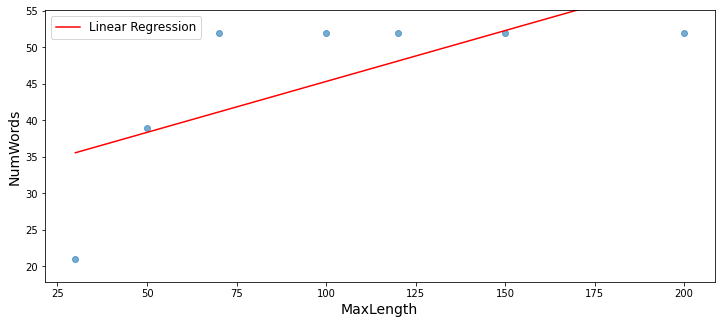

Correlation value 0.6825001439158869
P-value -
Coefficients: 
 [0.01409015] 
Intercept: 
 5.6409455209165005
R-square: 0.47


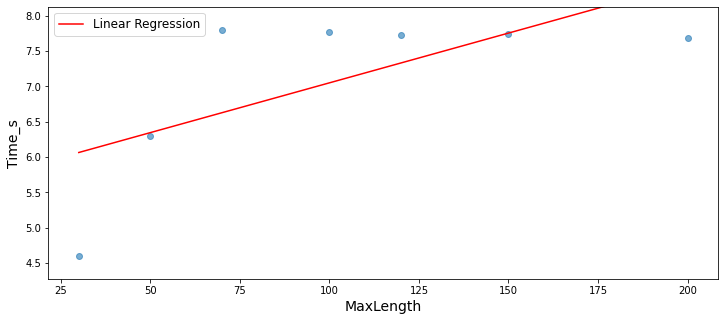

In [7]:
make_scatter_plot(df=df_result, x_feat="MaxLength", x_name="MaxLength", y_feat="NumWords", y_name="NumWords")

make_scatter_plot(df=df_result, x_feat="MaxLength", x_name="MaxLength", y_feat="Time_s", y_name="Time_s")

In [8]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [9]:
all_df_list = []
for conv in os.listdir("../Conversations/"):
    excel_name = [file for file in os.listdir("../Conversations/" + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel("../Conversations/" + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 6


In [10]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [11]:
summary_conv_list = []
for i_text, df_text in enumerate(all_df_list):

    all_text_paired = list(zip(df_text["Source"].values, df_text["EnglishMessage"].values))

    for i_tt, text_tuple in enumerate(all_text_paired):
        text_list = [": ".join(text) for text in all_text_paired[:i_tt]]
        whole_text = " ".join(text_list)
        
        if len(whole_text.split()) > 50:
            
            print("Conversation id", i_text, "sentence id", i_tt, end="\r")
            
            t0 = time.time()
            answer = summarizer(whole_text, max_length=100, min_length=10)
            elapsed_time = time.time() - t0

            summary_conv_list.append({
                "ConversationId": i_text,
                "InitialText": whole_text,
                "NumWordsOriginalText": len(whole_text.split()),
                "SummaryText": answer[0]["summary_text"],
                "NumWordsSummary": len(answer[0]["summary_text"].split()),
                "Time_s": elapsed_time,
            })
    

Your max_length is set to 100, but you input_length is only 97. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Your max_length is set to 100, but you input_length is only 96. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Your max_length is set to 100, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Your max_length is set to 100, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Your max_length is set to 100, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


In [12]:
df_summary_conv = pd.DataFrame(summary_conv_list)
df_summary_conv.to_csv("SummaryResults.csv", index=False)
df_summary_conv

,ConversationId,InitialText,NumWordsOriginalText,SummaryText,NumWordsSummary,Time_s
0,0,Person: What's your name? Bot: My name is Sus...,74,Susan is a college graduate who works as a gro...,28,3.486181
1,0,Person: What's your name? Bot: My name is Sus...,83,Susan is a college graduate. She works at a gr...,28,3.286988
2,0,Person: What's your name? Bot: My name is Sus...,97,Susan is a college graduate. She works at a gr...,19,2.470251
3,0,Person: What's your name? Bot: My name is Sus...,111,Susan is a college graduate who works as a gro...,28,3.260965
4,0,Person: What's your name? Bot: My name is Sus...,125,Susan is a college graduate. She works at a gr...,21,2.821580
...,...,...,...,...,...,...
87,5,Person: What's your name? Bot: My name is Sus...,69,"Bot: My name is Susan, and I am a college gra...",23,3.013739
88,5,Person: What's your name? Bot: My name is Sus...,84,"Bot: My name is Susan, and I am a college gra...",24,3.166609
89,5,Person: What's your name? Bot: My name is Sus...,89,"Bot: My name is Susan, and I am a college gra...",20,2.819576
90,5,Person: What's your name? Bot: My name is Sus...,98,Susan is a college graduate and works as a dat...,15,2.059909


In [13]:
index = -2

print("The text -> ", df_summary_conv["InitialText"].iloc[index])
print()
print("Number of words in original text-> ", df_summary_conv["NumWordsOriginalText"].iloc[index])
print()
print("The summary -> ", df_summary_conv["SummaryText"].iloc[index])
print()
print("Number of words in summary -> ", df_summary_conv["NumWordsSummary"].iloc[index])

The text ->  Person: What's your name? Bot:  My name is Susan, and I am a college graduate. I have a good job. Person: Hello Susan, how are you? Bot:  Hi, I am doing well. How are you doing? I am good. Person: I'm very good, my name is Jose Bot:  Hi Jose, nice to meet you. What do you do for a living? Person: Well, am I data analyst and you? Bot:  I'm not sure what you mean by that, but I work as an accountant. Person: Well, gotta go, bye Bot:  Goodbye, I hope you have a great day!?!

Number of words in original text->  98

The summary ->  Susan is a college graduate and works as a data analyst. Jose is an accountant.

Number of words in summary ->  15


In [14]:
stat_print(df_summary_conv["NumWordsSummary"], "Number of words in summary")

Mean Number of words in summary = 30.7826 +/- 10.684 ; Median = 28.0 ; Min. =  15 ; Max. =  57


Correlation value 0.5817468516443656
P-value ***
Coefficients: 
 [0.05028343] 
Intercept: 
 19.18298649331235
R-square: 0.34


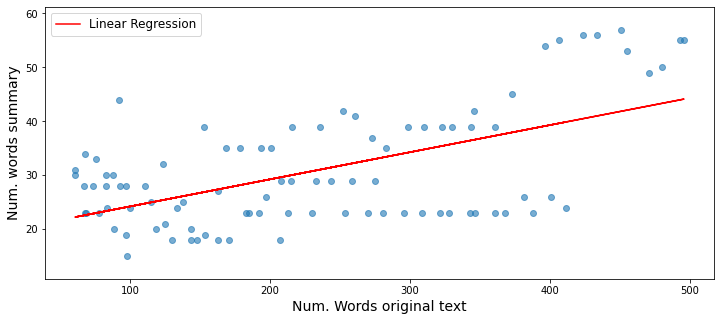

In [15]:
make_scatter_plot(df=df_summary_conv, 
                  x_feat="NumWordsOriginalText", 
                  x_name="Num. Words original text", 
                  y_feat="NumWordsSummary", 
                  y_name="Num. words summary")

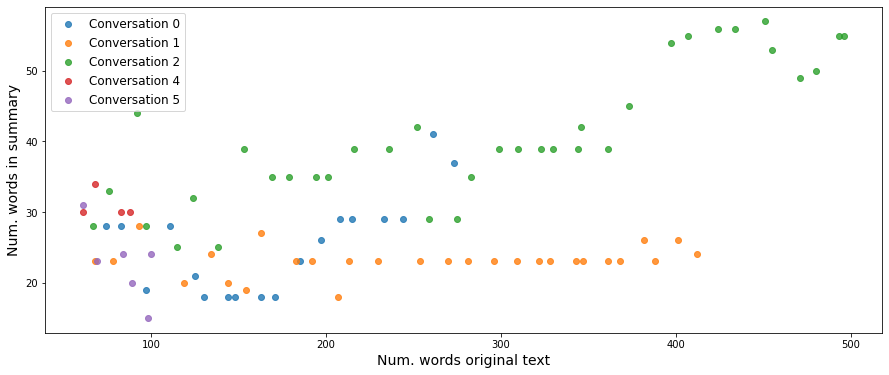

In [16]:
plt.figure(figsize=(15, 6))
for conv_id, df_sub_conv in df_summary_conv.groupby("ConversationId"):
    
    plt.scatter(df_sub_conv["NumWordsOriginalText"], df_sub_conv["NumWordsSummary"], 
                label="Conversation "+str(conv_id), alpha=0.8)

plt.xlabel("Num. words original text", fontsize=14)
plt.ylabel("Num. words in summary", fontsize=14)
plt.legend(fontsize=12)
    
plt.show()

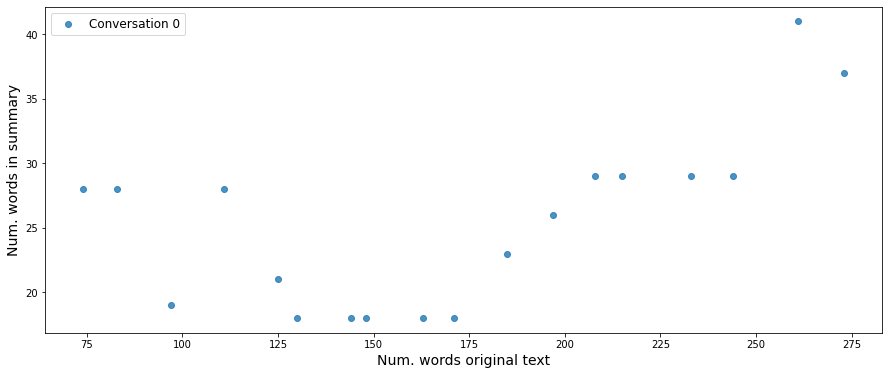

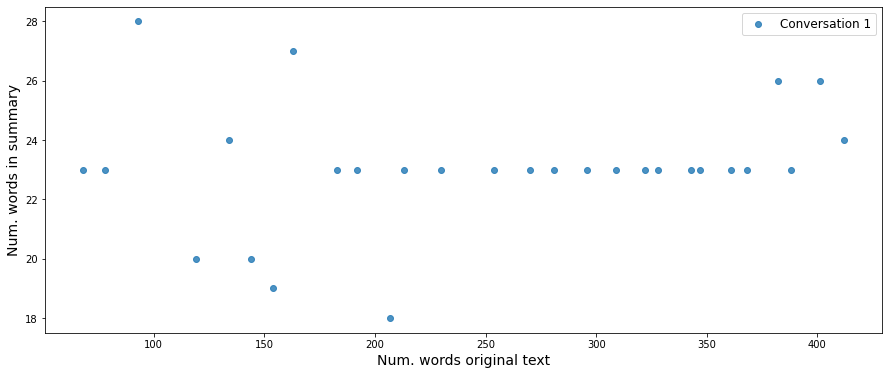

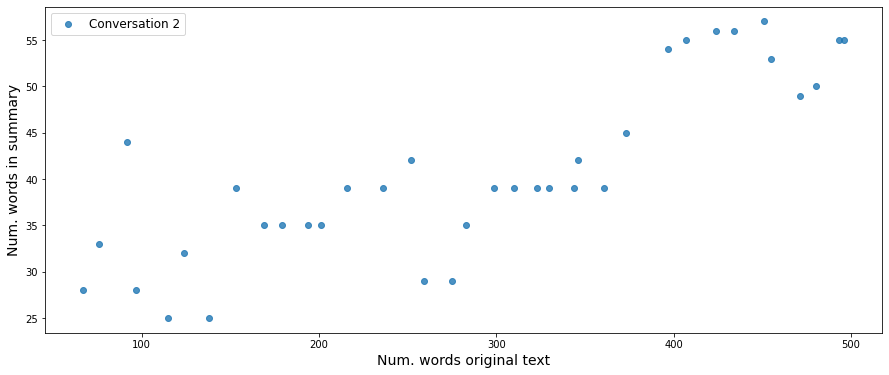

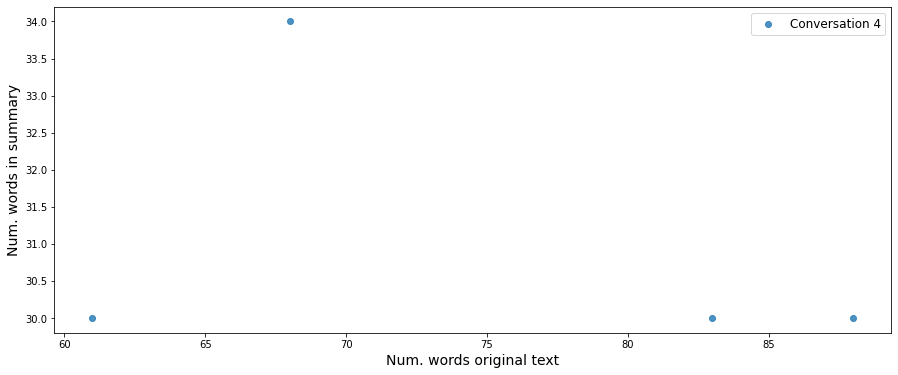

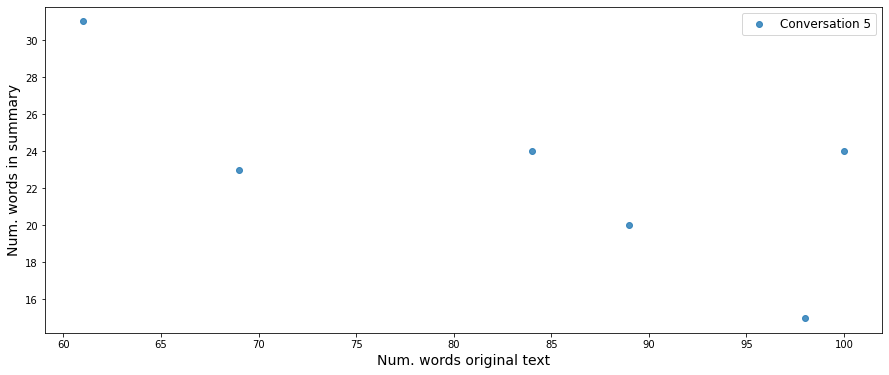

In [17]:
for conv_id, df_sub_conv in df_summary_conv.groupby("ConversationId"):
    
    plt.figure(figsize=(15, 6))
    plt.scatter(df_sub_conv["NumWordsOriginalText"], df_sub_conv["NumWordsSummary"], 
                label="Conversation "+str(conv_id), alpha=0.8)

    plt.xlabel("Num. words original text", fontsize=14)
    plt.ylabel("Num. words in summary", fontsize=14)
    plt.legend(fontsize=12)

    plt.show()